__Import the required modules__

In [1]:
#NLP Modules
import spacy
nlp = spacy.load('en_core_web_sm')
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import enchant
d = enchant.Dict("en_UK")


#Statistics Modules
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import coo_matrix

__Read the text file__

In [2]:
fp = open('fess103_txt.txt', 'r')
text = str(fp.read())
fp.close()

__Extract custom stop words__

In [3]:
#Stop-words are the words most common words in any language. eg: the, is,on. These need to be filtered out.
#Spacy has an in built corpus of stop words.
#In addition to this, it is important to filter out some dataset specific stop-words.

word_count = {}                                               #Dictionary to hold the frequencies of every word.
for word in text.split():
    if word in word_count.keys():
        word_count[word] +=1
    else:
        word_count[word] = 1


frequencies = [v for v in word_count.values()]
threshold = np.percentile(frequencies, 95)                   #Threshold frequency is chosen as the 95th percentile

#Creating custom stop-words list
s_w = ['chapter', 'ncert', 'class', 'years',                 #Basic stop-words for a textbook
       'thousands', 'notice', 'list', 'suggest']    
for k, v in word_count.items():
    if v>threshold:
        if not nlp.vocab[k].is_stop:                         #Check is the word isn't a pre-existing stop word
            s_w.append(k)

def custom_stop_words(word):                                 #Function to add to the default stop words
    if not nlp.vocab[word].is_stop:
        nlp.Defaults.stop_words.add(word)
        nlp.vocab[word].is_stop = True

for word in s_w:
    custom_stop_words(word)
    
print("STOP WORDS ADDED:", s_w, sep = '\n')

STOP WORDS ADDED:
['chapter', 'ncert', 'class', 'years', 'thousands', 'notice', 'list', 'suggest', 'The', 'buildings', 'years', 'ago,', 'city', 'found', 'cities', 'These', 'think', 'special', '‘These', 'This', 'stone', 'In', 'A', '—', 'probably', 'people', 'Harappan', 'They', 'men', ':', 'known', 'Harappans', 'find', 'buried', 'languages']


__Split the chapter into sections__

In [4]:
text_ = text.split("\n\n")
text_ = [each.replace('\n', ' ') for each in text_]                    #Method : A section header does not end with a punctuation
                                                                       #and is followed by \n\n
    
index = 0
section_text = [""]                                                    #List to hold section text
section_headers = []                                                   #List to hold section headers
for para in text_:
    if nlp.vocab[para[-1]].is_punct or ':' in para:
        section_text[index] += " " +para
    else:
        if(len(para) < 50 and len(para) > 4 and para[0].isupper()):    #Little text paragraphs are ignored as they desc images
            if not section_text[index] == "":
                index +=1
                section_text.append(para + '.')
            else:
                section_text[index] += para
            section_headers.append(para)
        else:
            section_text[index] += " " + para

print("NUMBER OF SECTIONS:",len(section_headers), sep = '\n')

NUMBER OF SECTIONS:
20


In [5]:
#The first section created includes the heading, with words that'll recur through all sections, and hence, can be removed.
#They are added on as stop words

more_sw = []
for i in nlp(" ".join(section_text[0].split())):
    word = i.lemma_
    if len(word)>1:
        if not word in s_w:
            more_sw.append(word.lower())
            
section_text = [para for para in section_text if len(para)>50]  

for word in more_sw:
    custom_stop_words(word)

In [6]:
#List to contain all the keywords.To prevent the addition of pre-existing keywords.
keyword_vocab = []

### 1. Extraction of noun chunks from each section

In [7]:
noun_chunks = {}

def find_nchunks(section):
    chunks = []                                                             #List of all the noun chunks in a section
    for chunk in section.noun_chunks:
        chunks.append(nlp(chunk.text))
        
    filtered_chunks = []                                                    #List of partially processed and filtered chunks
    for chunk in chunks:
        chunk_new = ""
        for word in chunk:
            word_ = nlp.vocab[word.lemma_]                                  #Filter conditions
            if not word_.is_stop:                                           #Not a stop word
                if not word_.text == '-PRON-':                              #Not a pronoun
                    if nlp.vocab[word_.text].is_alpha:                      #Not numeric/with junk characters
                        if not chunk_new == "":
                            chunk_new += " "
                        chunk_new += word.text
                        keyword_vocab.append((word.text).lower())           #Adds word to the keyword vocab
        if not chunk_new == "" and chunk_new.lower() not in keyword_vocab:
            filtered_chunks.append(chunk_new)
    return filtered_chunks

index = 1
for para in section_text:
    noun_chunks['Section ' + str(index)] = list(set(find_nchunks(nlp(para))))
    index += 1
            
print((noun_chunks['Section 1']))

['Notte Great Bath', 'Bie ries cig archaeologists', 'elaborate store', 'unque object', 'interlocking pattern', 'red walls', 'ARABIAN SEA', 'sseronslap houses', 'smaller fesshon Horyanaane', 'new construction', 'railway lines', 'old buildings', 'similar buildings', 'fire altars', 'baked brick', 'high quality bricks', 'natural tar', 'rich source', 'copper tool']


### 2. Extraction of keywords from each section.

__Add named entities to raw keyword list__

In [8]:
doc = [nlp(section) for section in section_text]

def create_ent_list(section):
    ent_list = set([ent.text for ent in section.ents if not ent.label_ in ["ORDINAL", "CARDINAL"]
                    and (ent.text).lower() not in keyword_vocab
                    and nlp.vocab[ent.text].is_alpha 
                    and not nlp.vocab[(ent.text).lower()].is_stop
                    and len((ent.text).split())<2])
    return ent_list

#Create a dictionary to hold keywords to demarcate sections.
#Later, will have the key-value pairs section segmented.

raw_keywords = {}  
index = 1
for i in doc:
    raw_keywords["Section " + str(index)] = list(create_ent_list(i))
    index += 1
    
print(raw_keywords['Section 9'])

['Indo', 'German', 'Match', 'French', 'Italian', 'Greek']


__Pre-Processing the text__

In [9]:
def preprocess(text):

    # 1. Removing punctuations
    text = re.sub('[^a-zA-Z]', ' ', text)

    # 2. Convert to lower case
    text = text.lower()

    # 3. Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # 4. Remove special characters
    text = re.sub("(\W)+", " ", text)

    # 5. Convert to list
    text = text.split()
    return text

index = 0
for text in section_text:
    section_text[index] = preprocess(text)
    index += 1

print('PRE-PROCESSED TEXT:', section_text[0][:20], sep = '\n')

PRE-PROCESSED TEXT:
['the', 'story', 'of', 'hatappa', 'very', 'often', 'old', 'buildings', 'have', 'a', 'story', 'to', 'tell', 'nearly', 'a', 'hundred', 'and', 'fifty', 'years', 'ago']


_Lemmatization_

In [10]:
#Lemmatization

lemmatized_list = []

for section in doc:
    l = []
    for token in section:
        l.append(token.lemma_)
    lemmatized_list.append(l)
    
print("LEMMATIZED TEXT:", lemmatized_list[0][:20], sep = '\n')

LEMMATIZED TEXT:
['the', 'story', 'of', 'hatappa', '.', 'very', 'often', ',', 'old', 'building', 'have', 'a', 'story', 'to', 'tell', '.', 'nearly', 'a', 'hundred', 'and']


_Removing stop words_

In [11]:
filtered_list = []

for section in lemmatized_list:
    section = nlp(" ".join(section))
    l = []
    for token in section:
        if not token.is_stop:
            if not token.is_punct:
                if not token.text == '-PRON-':
                    l.append(token.text)
    filtered_list.append(l)

print("FILTERED TEXT:", filtered_list[0][:20], sep = '\n')

FILTERED TEXT:
['story', 'hatappa', 'old', 'building', 'story', 'tell', 'nearly', 'year', 'ago', 'railway', 'line', 'lay', 'time', 'punjab', 'engineer', 'stumble', 'site', 'harappa', 'present', 'day']


### 3. Text Feature Extraction

__Preliminary Data Exploration__

             Word  Freq
0             use    30
1            know    16
2            year    15
3             ago    14
4        describe    13
5           river    13
6          burial    13
7        language    13
8         rigveda    13
9        building    12
10       harappan    12
11          large    12
12          house    12
13            man    12
14  archaeologist    11
15           bead    11
16          water    11
17          place    11
18          write    11
19           bury    11


C:\Users\manah\.conda\envs\nlp_course\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ago', 'harappan', 'harappans', 'pasts'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[Text(0, 0, 'use'),
 Text(0, 0, 'know'),
 Text(0, 0, 'year'),
 Text(0, 0, 'ago'),
 Text(0, 0, 'describe'),
 Text(0, 0, 'river'),
 Text(0, 0, 'burial'),
 Text(0, 0, 'language'),
 Text(0, 0, 'rigveda'),
 Text(0, 0, 'building'),
 Text(0, 0, 'harappan'),
 Text(0, 0, 'large'),
 Text(0, 0, 'house'),
 Text(0, 0, 'man'),
 Text(0, 0, 'archaeologist'),
 Text(0, 0, 'bead'),
 Text(0, 0, 'water'),
 Text(0, 0, 'place'),
 Text(0, 0, 'write'),
 Text(0, 0, 'bury')]

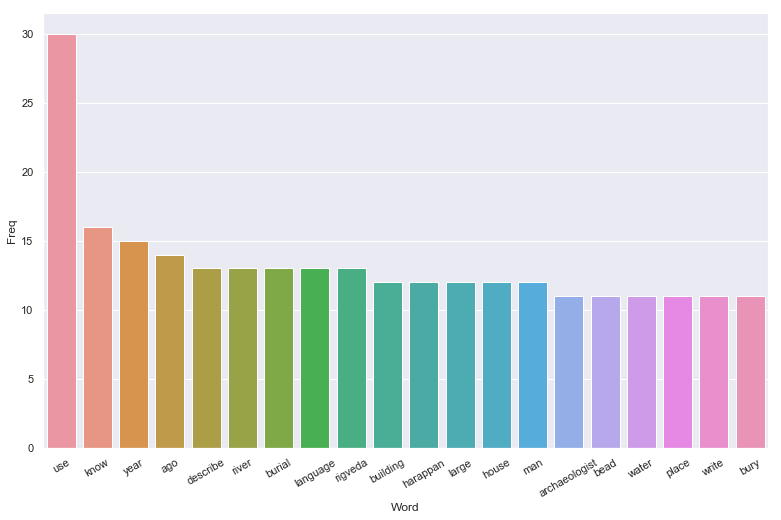

In [12]:
l = []                                                          #Create a list of all the words
for section in filtered_list:
    for word in section:
        l.append(word)

    
count_vector = CountVectorizer(max_df = 0.8, stop_words = nlp.Defaults.stop_words,
                               max_features = 10000, ngram_range = (1,3))
x = count_vector.fit_transform(l)

#Most frequently occuring words

def get_top_n_words(text, n = None):
    vec = CountVectorizer().fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

top_words = get_top_n_words(l, n=20)

#Convert to datframe for plotting
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
print(top_df)

#Plotting n-grams - Mono
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)


              Bi-gram  Freq
0            year ago    13
1        raw material     7
2         present day     6
3        old building     5
4         gold silver     5
5           man woman     4
6       farmer herder     4
7      language speak     4
8   illustration page     3
9   look illustration     3
10      reason answer     3
11    family language     3
12      belong family     3
13           map page     3
14      describe term     3
15          term work     3
16      work language     3
17          jana vish     3
18       railway line     2
19       day pakistan     2


[Text(0, 0, 'year ago'),
 Text(0, 0, 'raw material'),
 Text(0, 0, 'present day'),
 Text(0, 0, 'old building'),
 Text(0, 0, 'gold silver'),
 Text(0, 0, 'man woman'),
 Text(0, 0, 'farmer herder'),
 Text(0, 0, 'language speak'),
 Text(0, 0, 'illustration page'),
 Text(0, 0, 'look illustration'),
 Text(0, 0, 'reason answer'),
 Text(0, 0, 'family language'),
 Text(0, 0, 'belong family'),
 Text(0, 0, 'map page'),
 Text(0, 0, 'describe term'),
 Text(0, 0, 'term work'),
 Text(0, 0, 'work language'),
 Text(0, 0, 'jana vish'),
 Text(0, 0, 'railway line'),
 Text(0, 0, 'day pakistan')]

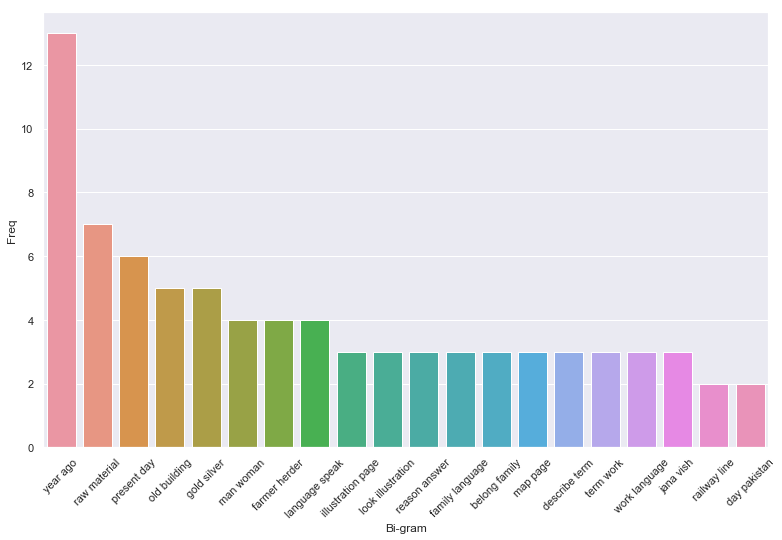

In [13]:
f_l = []                                                                               #List of all the sections
for i in range(len(filtered_list)):
    f_l.append(" ".join(filtered_list[i]))
    
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(f_l, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                  Tri-gram  Freq
0       describe term work     3
1      work language speak     3
2     present day pakistan     2
3   look illustration page     2
4        cattle sheep goat     2
5       term work language     2
6        word use describe     2
7            3000 year ago     2
8        story hatappa old     1
9     hatappa old building     1
10      old building story     1
11     building story tell     1
12       story tell nearly     1
13        tell nearly year     1
14         nearly year ago     1
15        year ago railway     1
16        ago railway line     1
17        railway line lay     1
18           line lay time     1
19         lay time punjab     1


[Text(0, 0, 'describe term work'),
 Text(0, 0, 'work language speak'),
 Text(0, 0, 'present day pakistan'),
 Text(0, 0, 'look illustration page'),
 Text(0, 0, 'cattle sheep goat'),
 Text(0, 0, 'term work language'),
 Text(0, 0, 'word use describe'),
 Text(0, 0, '3000 year ago'),
 Text(0, 0, 'story hatappa old'),
 Text(0, 0, 'hatappa old building'),
 Text(0, 0, 'old building story'),
 Text(0, 0, 'building story tell'),
 Text(0, 0, 'story tell nearly'),
 Text(0, 0, 'tell nearly year'),
 Text(0, 0, 'nearly year ago'),
 Text(0, 0, 'year ago railway'),
 Text(0, 0, 'ago railway line'),
 Text(0, 0, 'railway line lay'),
 Text(0, 0, 'line lay time'),
 Text(0, 0, 'lay time punjab')]

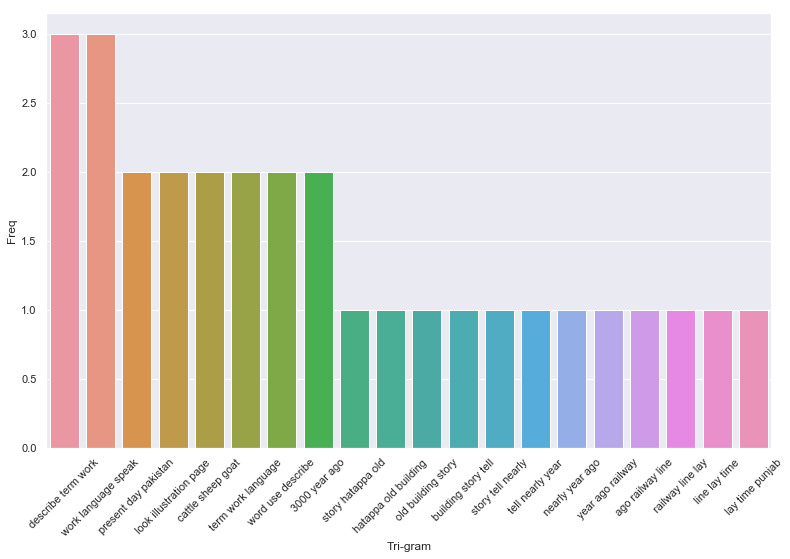

In [14]:
#Most frequently occuring Tri-grams

def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top3_words = get_top_n3_words(f_l, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Tri-grams

sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)


__Keyword Extraction using tf-idf method__

In [15]:
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(x)

#Get feature names
feature_names = count_vector.get_feature_names()
 
#Fetch sections from which keywords needs to be extracted
docs = []
for i in range(len(filtered_list)):
    docs.append(" ".join(filtered_list[i]))

#Generate tf-idf for the given document

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

index = 1
for doc in docs:
    keywords = []
    tf_idf_vector = tfidf_transformer.transform(count_vector.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items = sort_coo(tf_idf_vector.tocoo())
    #extract only the top n; n here is 10

    keywords = extract_topn_from_vector(feature_names,sorted_items,10)
    for k in keywords:
        if k not in keyword_vocab:
            keyword_vocab.append(k)
            raw_keywords['Section ' + str(index)].append(k)
        else:
            keyword_vocab.remove(k)
    index += 1
    
print((raw_keywords['Section 5']))
print(section_headers[4])

['grow', 'rear', 'plant', 'supply', 'live']
Food for people in, the cities


_Pre-Process noun chunks_

In [16]:
#preprocess() takes string as input and returns a word.

for section, text in noun_chunks.items():
    l = []
    for word in text:
        new_word = preprocess(word)
        l.append(" ".join(new_word))
    noun_chunks[section] = l
        
#noun_chunks['Section 3']

In [17]:
#Final raw keywords list.

for k in raw_keywords:
    raw_keywords[k] += noun_chunks[k]
    
for k in raw_keywords:
    raw_keywords[k] = raw_keywords[k]

In [21]:
print(section_headers[2], raw_keywords['Section 3'], sep = '\n\n')


New crafts in the city

['carve', 'craft', 'vessel', 'new crafts', 'beautiful black designs', 'copper objects', 'actual pieces', 'beena specialist', 'polishing beads', 'silver vase', 'expert crafts person', 'spindle whorls']


In [23]:
" ".join(section_text[2])

'new crafts in the city let us look at some of the objects that were made and found in harappan cities most of the things that have been found by archaeologists are made ofstone shell and metal including copper bronze gold and silver copper and bronze were used to make tools weapons ornaments and vessels gold and silver were used to make ornaments and vessels perhaps the most striking finds are those of beads weights and blades the harappans also made seals out of stone these are generally rectangular see illustration on page and usually have an animal carved on them the harappans also made pots with beautiful black designs such as the one shown on page was metal used in the villages you learnt about in chapter was stone used to make weights cotton was probably grown at mehrgarh from about years ago actual pieces of cloth were found attached to the lid of a silver vase and some copper objects at mohenjodaro archaeologists have also found spindle whorls in rumade of terracotta and faien